In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/boston/calendar.csv
/kaggle/input/boston/listings.csv
/kaggle/input/boston/reviews.csv
/kaggle/input/seattle/calendar.csv
/kaggle/input/seattle/listings.csv
/kaggle/input/seattle/reviews.csv


# Business Question

1. What are factors that have most impact on a house’s price?
2. Is there a trend in house prices?
3. which neighborhood has highest price? (related to number of listing and price in each neighborhood)

#  Data Understanding and EDA

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import RepeatedKFold

import xgboost as xgb

In [5]:
boston_listings= pd.read_csv('/kaggle/input/boston/listings.csv')
boston_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United Sta

In [6]:
all_columns= list(boston_listings.columns)

drop less information columns

In [7]:
url_cols= [col for col in all_columns if 'url' in col]
drop_cols= ['scrape_id','last_scraped','country', 'country_code', 'smart_location', 'street',
           ]


In [8]:
boston_listings['smart_location'].value_counts()
# Drop this col
#boston_listings[['smart_location','price']].
#sns.catplot(data=boston_listings[['smart_location','price']].dropna(), x="smart_location", y="price", kind="box")#,hue = "room_type")


Boston, MA                       3381
Roxbury Crossing, MA               24
Somerville, MA                     19
Jamaica Plain, MA                  18
Brookline, MA                      18
Cambridge, MA                      16
Dorchester, MA                     15
Brighton, MA                       15
Charlestown, MA                    15
Allston, MA                        12
Roslindale, MA                      6
West Roxbury, MA                    5
ROXBURY CROSSING, MA                4
Mattapan, MA                        3
East Boston, MA                     3
ALLSTON, MA                         2
Boston, Massachusetts, US, MA       2
South Boston, MA                    2
Jamaica Plain, Boston, MA           2
Hyde Park, MA                       2
Jamaica Plain , MA                  2
MA                                  2
Roslindale, Boston, MA              1
dorchester, boston , MA             1
Milton, MA                          1
Jamaica Plain (Boston), MA          1
Newton, MA  

In [9]:
boston_listings['market'].value_counts()
# drop this col

Boston                   3568
San Francisco               1
Other (Domestic)            1
Other (International)       1
Name: market, dtype: int64

In [10]:
boston_listings['interaction'].isna().sum()
# too much missing -> drop

1554

In [11]:
available_cols = [col for col in all_columns if 'available' in col or  'availability' in col]
print(available_cols)

['has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365']


In [12]:
boston_listings['calendar_updated'].value_counts()
# the last time may have some useful informations

today            833
a week ago       340
2 weeks ago      307
3 weeks ago      221
yesterday        174
4 days ago       168
2 months ago     165
4 weeks ago      158
5 days ago       132
3 months ago     131
5 weeks ago      128
3 days ago       101
2 days ago        98
4 months ago      85
6 weeks ago       81
5 months ago      56
7 months ago      43
7 weeks ago       37
10 months ago     37
1 week ago        36
6 days ago        36
9 months ago      35
8 months ago      32
6 months ago      32
14 months ago     19
13 months ago     19
never             19
11 months ago     17
12 months ago     13
17 months ago      9
15 months ago      8
16 months ago      7
25 months ago      2
18 months ago      2
22 months ago      1
30 months ago      1
23 months ago      1
20 months ago      1
Name: calendar_updated, dtype: int64

In [13]:
boston_calendar= pd.read_csv('/kaggle/input/boston/calendar.csv')
boston_calendar.shape

(1308890, 4)

In [14]:
boston_calendar['date'] =pd.to_datetime(boston_calendar['date'])

In [15]:
boston_calendar["available"]=boston_calendar["available"].apply(lambda x:1 if x=="t" else 0)


In [16]:
boston_calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,0,NaN
1,12147973,2017-09-04,0,NaN
2,12147973,2017-09-03,0,NaN
3,12147973,2017-09-02,0,NaN
4,12147973,2017-09-01,0,NaN


In [17]:
boston_calendar['day_of_week'] = boston_calendar['date'].apply(lambda x: x.weekday())

In [18]:
boston_calendar['month'] = boston_calendar['date'].apply(lambda x: x.month)

In [19]:
boston_calendar.head()

,listing_id,date,available,price,day_of_week,month
0,12147973,2017-09-05,0,NaN,1,9
1,12147973,2017-09-04,0,NaN,0,9
2,12147973,2017-09-03,0,NaN,6,9
3,12147973,2017-09-02,0,NaN,5,9
4,12147973,2017-09-01,0,NaN,4,9


In [20]:
available_calendar_bostion_col = [col for col in list(boston_calendar.columns) if 'available' in col or 'availability' in col]
available_calendar_bostion_col

['available']

In [21]:
#available_rate by day
boston_calendar_avaible_rate=boston_calendar.groupby('date')['available'].agg(['sum','mean']).reset_index()
boston_calendar_avaible_rate.set_index('date', inplace=True)
boston_calendar_avaible_rate.index

DatetimeIndex(['2016-09-06', '2016-09-07', '2016-09-08', '2016-09-09', '2016-09-10', '2016-09-11', '2016-09-12', '2016-09-13', '2016-09-14', '2016-09-15',
               ...
               '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31', '2017-09-01', '2017-09-02', '2017-09-03', '2017-09-04', '2017-09-05'], dtype='datetime64[ns]', name='date', length=365, freq=None)

<Axes: xlabel='date'>

<Figure size 1000x500 with 0 Axes>

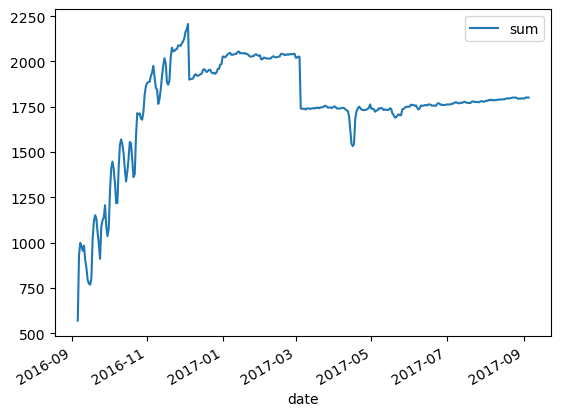

In [22]:
plt.figure(figsize=(10,5))
#boston_calendar_avaible_rate.drop('sum',axis=1).plot(x_compat=True)
boston_calendar_avaible_rate.drop('mean',axis=1).plot(x_compat=True)

In [23]:
# all the available is not nan price
sum(boston_calendar['price'].isna().apply(lambda x: int(x)) - (1-boston_calendar['available']))

0

In [24]:
boston_calendar_price= boston_calendar[boston_calendar['price'].isna()==False]
boston_calendar_price['price'] = boston_calendar_price['price'].str.extract(r'(\d+)').apply(pd.to_numeric)
boston_calendar_price.head()

/tmp/ipykernel_32/52403381.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boston_calendar_price['price'] = boston_calendar_price['price'].str.extract(r'(\d+)').apply(pd.to_numeric)


,listing_id,date,available,price,day_of_week,month
365,3075044,2017-08-22,1,65,1,8
366,3075044,2017-08-21,1,65,0,8
367,3075044,2017-08-20,1,65,6,8
368,3075044,2017-08-19,1,75,5,8
369,3075044,2017-08-18,1,75,4,8


<Axes: xlabel='date'>

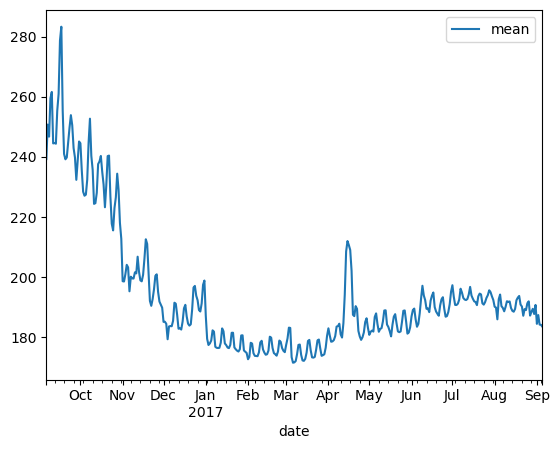

In [25]:
# plot mean price of all listing_id by date
boston_calendar_price.groupby('date').agg(['mean'])['price'].plot()


In [26]:
boston_calendar_price.groupby('date').agg(['mean'])['price'].tail()

,mean
date,
2017-09-01,184.457382
2017-09-02,187.372636
2017-09-03,184.200888
2017-09-04,184.129928
2017-09-05,183.523043


We can see a downtrend about listing price in the late of 2016. From the average price graph and the above available rate graph, I have an assumption that there was an abnormal event occur in the last months of 2016 at Boston, then the supply was scarcer and the listed price was pushed up. The average price in summer months(June, July, August of 2017) is higher than spring months (January, February, March of 2017). There was also a peak of price in mid of April 2017, this can help for future analyze.

<Axes: xlabel='day_of_week'>

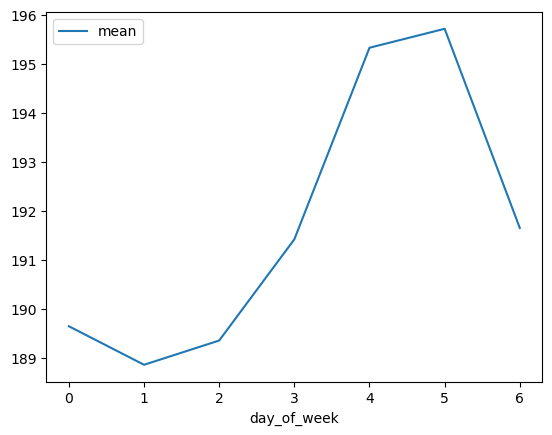

In [27]:
boston_calendar_price.groupby('day_of_week').agg(['mean'])['price'].plot()

The average price by day_of_week graph show that the listed price in highest at Friday and Saturday. The general trend is price increase from Tuesday and get highest at Saturday, then it decrease from Sunday to the next Tuesday. 

Next, I will analyze text data about amenities of all listings to find which is factor most influence to price.

In [28]:
# all amenities
amenities = boston_listings['amenities'].apply(lambda x: list(x.replace('{', '').replace('}', '').replace('"', '').split(',')))

amenities.shape

(3585,)

In [29]:
#one-hot labeling for each amenities
mlb = MultiLabelBinarizer()
# create dataframe
df_amenities = pd.DataFrame(mlb.fit_transform(amenities), columns=mlb.classes_, index=amenities.index)
#drop meaningless columns
df_amenities.drop(columns  = ['translation missing: en.hosting_amenity_50', 'translation missing: en.hosting_amenity_49', ''], inplace=True)
# concat with price 
price_amenities= pd.concat([boston_listings['price'].str.extract(r'(\d+)').apply(pd.to_numeric),df_amenities], axis=1)
price_amenities.rename(columns={0:'price'}, inplace=True)
price_amenities.head(5)

,price,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,Dryer,Elevator in Building,Essentials,Family/Kid Friendly,Fire Extinguisher,First Aid Kit,Free Parking on Premises,Free Parking on Street,Gym,Hair Dryer,Hangers,Heating,Hot Tub,Indoor Fireplace,Internet,Iron,Kitchen,Laptop Friendly Workspace,Lock on Bedroom Door,Other pet(s),Paid Parking Off Premises,Pets Allowed,Pets live on this property,Pool,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet
0,250,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1
1,65,0,1,0,0,0,1,0,1,0,1,0,1,1,1,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1
2,65,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,1,1,0,0,1
3,75,0,1,1,0,0,1,0,0,0,1,0,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,1
4,79,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1


In [30]:
# ratio of each amenity
print(df_amenities.mean().sort_values(ascending= False)[:5])

Wireless Internet             0.954254
Heating                       0.943933
Kitchen                       0.916039
Essentials                    0.835146
Smoke Detector                0.811994
Air Conditioning              0.786890
TV                            0.727197
Internet                      0.718828
Dryer                         0.690656
Washer                        0.690377
Carbon Monoxide Detector      0.681172
Shampoo                       0.675314
Hangers                       0.553696
Family/Kid Friendly           0.526639
Laptop Friendly Workspace     0.511576
Iron                          0.509902
Hair Dryer                    0.505160
Cable TV                      0.493724
Fire Extinguisher             0.441283
24-Hour Check-in              0.347838
First Aid Kit                 0.296513
Elevator in Building          0.242120
Buzzer/Wireless Intercom      0.234031
Free Parking on Premises      0.231799
Pets Allowed                  0.135565
Gym                      

The amenities that appear the most are: Wifi (>95%), Heating (>94%), Kitchen (>91%). 

<Axes: >

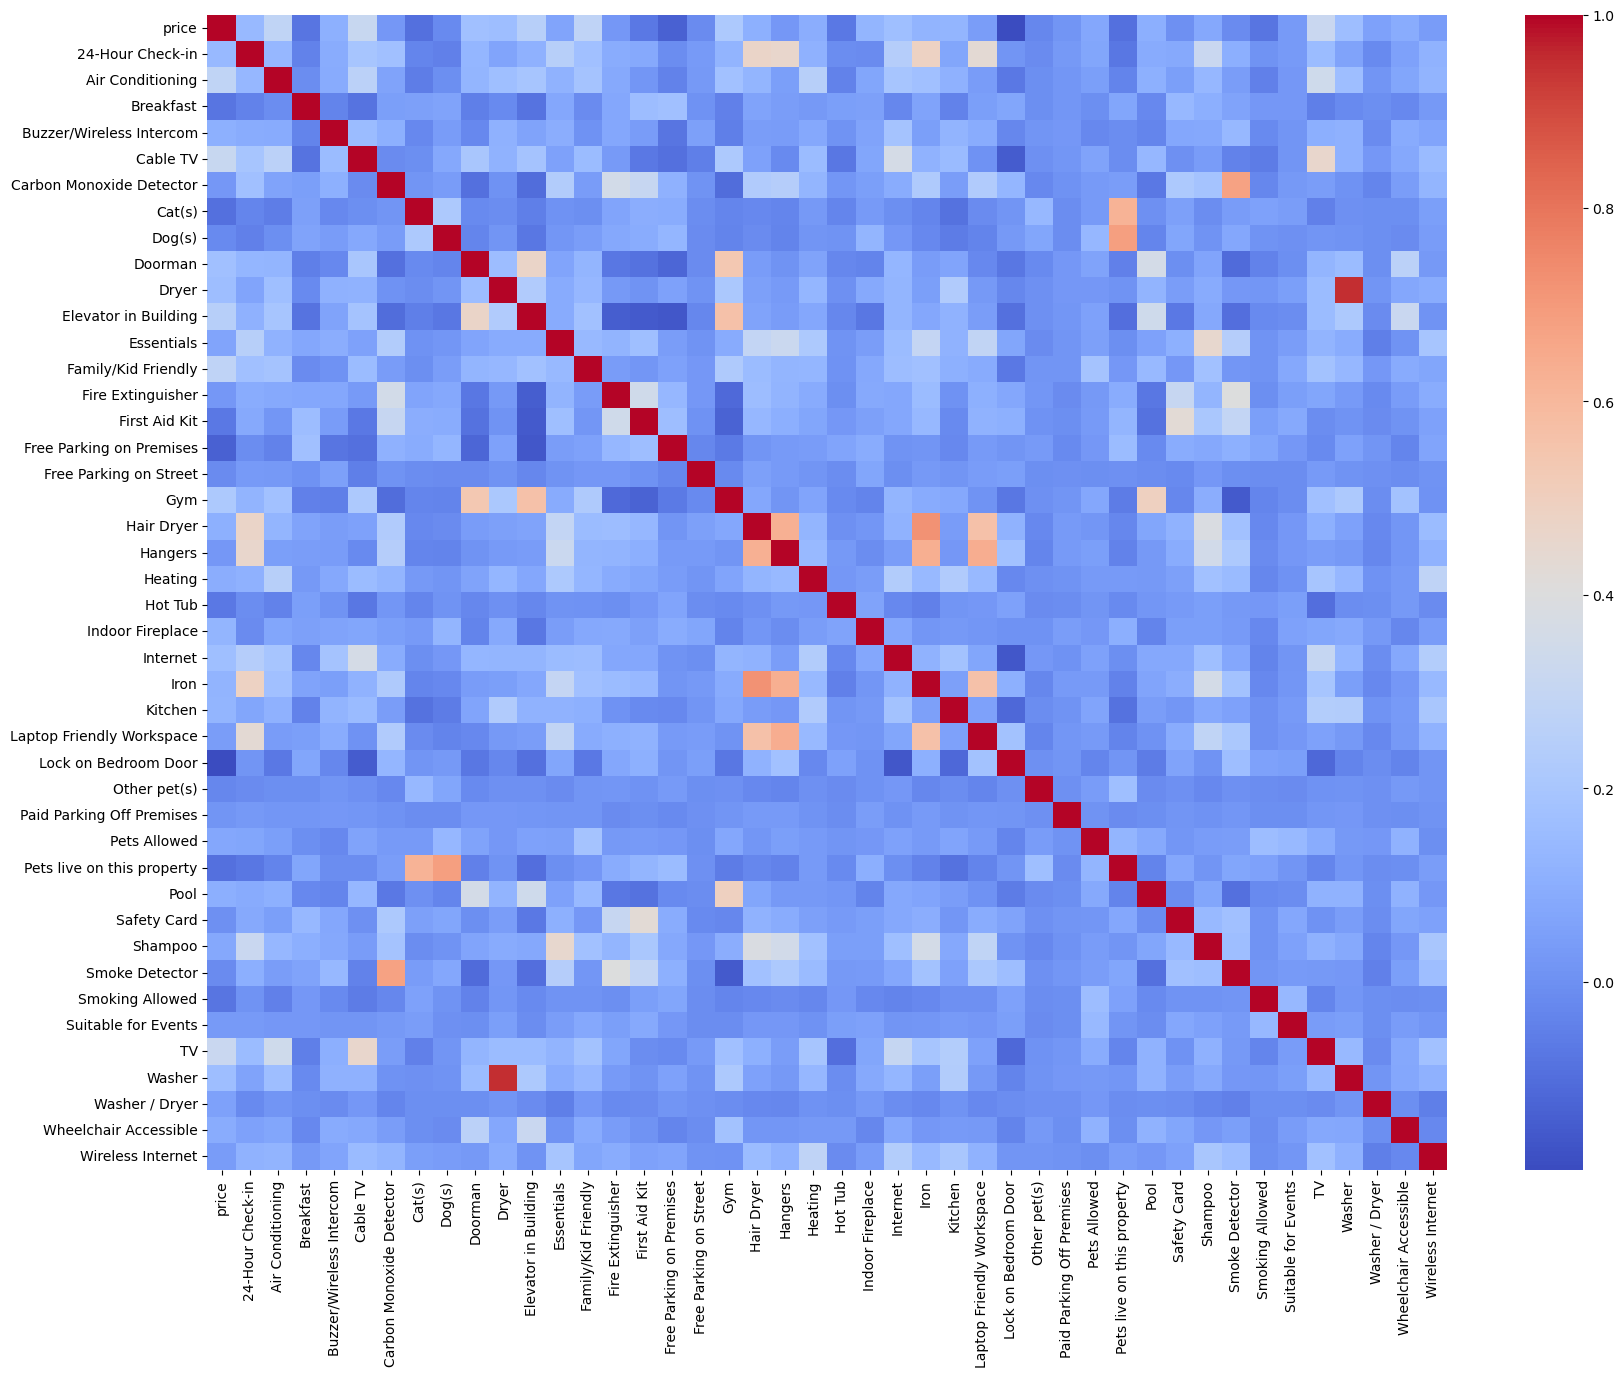

In [31]:
plt.figure(figsize=(20,15))
sns.heatmap(price_amenities.corr(), annot=False,cmap = 'coolwarm')

The amenities that have the highest correlation with price are TV, Air Conditioning, Elevator in Building, and Gym. Conversely, 'Lock on Bedroom Door' and 'Free Parking on Premises' correlate most negatively with the price, which mean that the room seem to be cheaper if it doesn't have a lock for bedroom and more expensive if it has free parking on premises.

Next, I explore the relationship between Listing Neighbor and Price

In [32]:
neighbor_col = [col for col in all_columns if 'neighb' in col]
neighbor_price = boston_listings[['price']+neighbor_col]
neighbor_price['price']= neighbor_price['price'].str.extract(r'(\d+)').apply(lambda x: pd.to_numeric(x))

neighbor_price.head()

/tmp/ipykernel_32/2169142492.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbor_price['price']= neighbor_price['price'].str.extract(r'(\d+)').apply(lambda x: pd.to_numeric(x))


,price,neighborhood_overview,host_neighbourhood,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
0,250,"Roslindale is quiet, convenient and friendly. ...",Roslindale,Roslindale,Roslindale,NaN
1,65,"The room is in Roslindale, a diverse and prima...",Roslindale,Roslindale,Roslindale,NaN
2,65,The LOCATION: Roslindale is a safe and diverse...,Roslindale,Roslindale,Roslindale,NaN
3,75,Roslindale is a lovely little neighborhood loc...,NaN,NaN,Roslindale,NaN
4,79,"I love the proximity to downtown, the neighbor...",Roslindale,Roslindale,Roslindale,NaN


/tmp/ipykernel_32/1265843829.py:1: FutureWarning: ['neighborhood_overview', 'host_neighbourhood', 'neighbourhood'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  neighbor_price_summary = neighbor_price.groupby('neighbourhood_cleansed').agg(['mean','std'])['price']


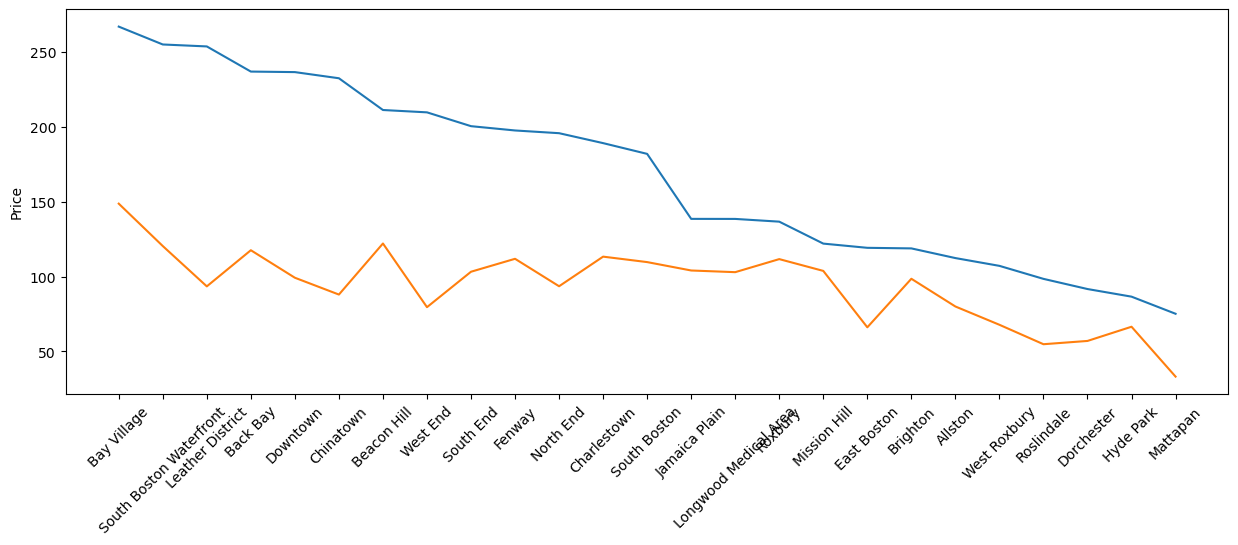

In [33]:
neighbor_price_summary = neighbor_price.groupby('neighbourhood_cleansed').agg(['mean','std'])['price']
#print(len(neighbor_price_summary.index))
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
plt.ylabel('Price')
plt.plot(neighbor_price_summary.sort_values(by='mean', ascending= False))

There is a noticeable variation in room rates between neighborhood. The neighborhood has highest average price is Bay Village and the lowest is Mattapan.
Higher-priced areas often have higher price volatility. 




# Prepare Data

In [34]:

def clean_col(list_df, alpha=0.5):
    # This function can be applied for both two datasets Seattle and Boston
    #alpha is drop rate for missing columns
    
    list_clean = list_df.copy()
    all_columns = list(list_df.columns)
    
    # remove columns may not have useful informations
    remove_cols = ['thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'listing_url', 'host_url',
       'host_thumbnail_url', 'host_picture_url', 'country', 'country_code', 
       'smart_location', 'street', 'market', 'first_review', 'last_review', 'state', 'calendar_last_scraped',
     'city', 'scrape_id', 'last_scraped', 'space', 
    'host_listings_count', 'zipcode', 'is_location_exact', 'host_location',
       'host_total_listings_count']
    
    neighbor_col = [col for col in all_columns if 'neighb' in col]

    list_clean.drop(columns= remove_cols + neighbor_col, inplace=True)
    
    #drop missing columns>alpha
    mis_cols = list_clean.columns[list_clean.isnull().sum()/list_clean.shape[0] > alpha]
    list_clean.drop(columns= mis_cols,inplace = True)
    
    
    rate_cols = ['host_response_rate', 'host_acceptance_rate', 'price', 'cleaning_fee', 'extra_people']
    for col in rate_cols:
        list_clean[col] = list_clean[col].str.extract(r'(\d+)')
        list_clean[col] = list_clean[col].astype('float128').astype('Int64')
    #print(list_clean[rate_cols].dtypes)
    list_clean['host_since'] = pd.to_datetime(list_clean.host_since)
    
    temp = pd.to_datetime('15/09/2017')
    
    list_clean['host_len'] = list_clean.host_since.apply(lambda x: pd.Timedelta(temp-x).days)
    list_clean = list_clean.drop('host_since', axis=1)
    
    #number of amenities
    list_clean['n_amenities'] = list_clean['amenities'].apply(lambda x: len(x.replace('{', '').replace('{', '').replace('"', '').split(',')))
    list_clean.drop('amenities', axis=1, inplace=True)
    
    return list_clean

In [35]:
boston_reviews= pd.read_csv('/kaggle/input/boston/reviews.csv')
boston_reviews.head()
# Analyze later

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [36]:
boston_list_clean=clean_col(boston_listings)


/tmp/ipykernel_32/5004794.py:32: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  temp = pd.to_datetime('15/09/2017')


In [97]:
boston_list_clean['bathrooms'].unique()


array([1.5, 1. , 2. , 0. , 2.5, 3.5, nan, 3. , 0.5, 4.5, 4. , 5. , 6. ])

In [91]:
# plt.figure()
# sns.histplot(boston_list_clean['calendar_updated'])
# plt.xticks(rotation =45)


In [39]:
object_col= boston_list_clean.select_dtypes(include=['object']).columns

In [40]:
for col in object_col:
    if 1< len(boston_list_clean[col].unique())<10:
        print(col)

host_response_time
host_is_superhost
host_has_profile_pic
host_identity_verified
room_type
bed_type
instant_bookable
cancellation_policy
require_guest_profile_picture
require_guest_phone_verification


<Axes: xlabel='review_scores_cleanliness', ylabel='Count'>

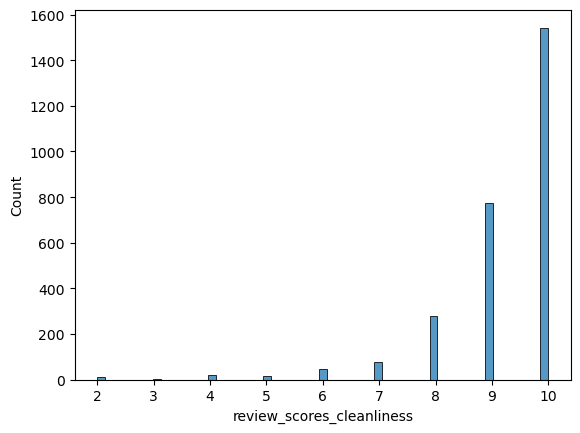

In [41]:
sns.histplot(boston_list_clean['review_scores_cleanliness'])

convert 

In [42]:
review_to_category={'10.0': 'Perfect', '9.0': 'Good', '8.0': 'Soso', 'nan': 'not_cmt'}
for i in range(8):
    review_to_category[str(float(i))] = 'Not good'


In [43]:
boston_list_clean['review_scores_location'].unique()

array([nan,  9., 10.,  7.,  8.,  2.,  6.,  4.,  5.,  3.])

In [44]:
boston_list_clean['review_convert'] = boston_list_clean['review_scores_location'].apply(lambda x: review_to_category[str(x).lower()] )

<Axes: xlabel='review_convert', ylabel='Count'>

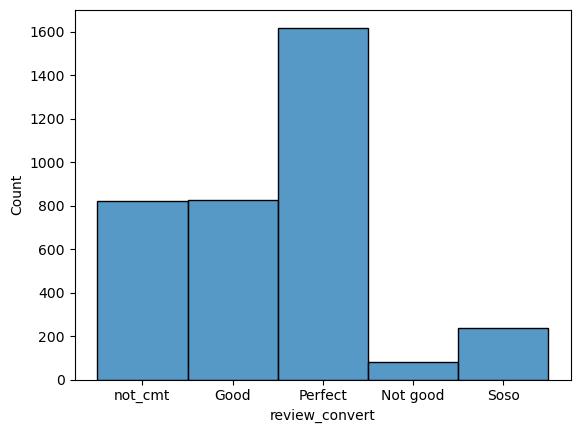

In [45]:
sns.histplot(boston_list_clean['review_convert'])

In [46]:
review_cols= [c for c in  boston_list_clean.columns if 'review' in c]
print(review_cols)
review_to_drop =['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

['number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'review_convert']


In [47]:
category_col = ['review_convert', 'host_is_superhost', 'host_identity_verified', 'bed_type', 'instant_bookable',
     'cancellation_policy', 'require_guest_profile_picture' , 'require_guest_phone_verification']

In [48]:
boston_list_clean.drop(columns = review_to_drop, inplace=True)

In [49]:
boston_cat = boston_list_clean[category_col]
boston_num = boston_list_clean.select_dtypes(include=['int', 'float'])
boston_list_get_dummies=pd.get_dummies(boston_cat, prefix= category_col)

<Figure size 2000x2000 with 0 Axes>

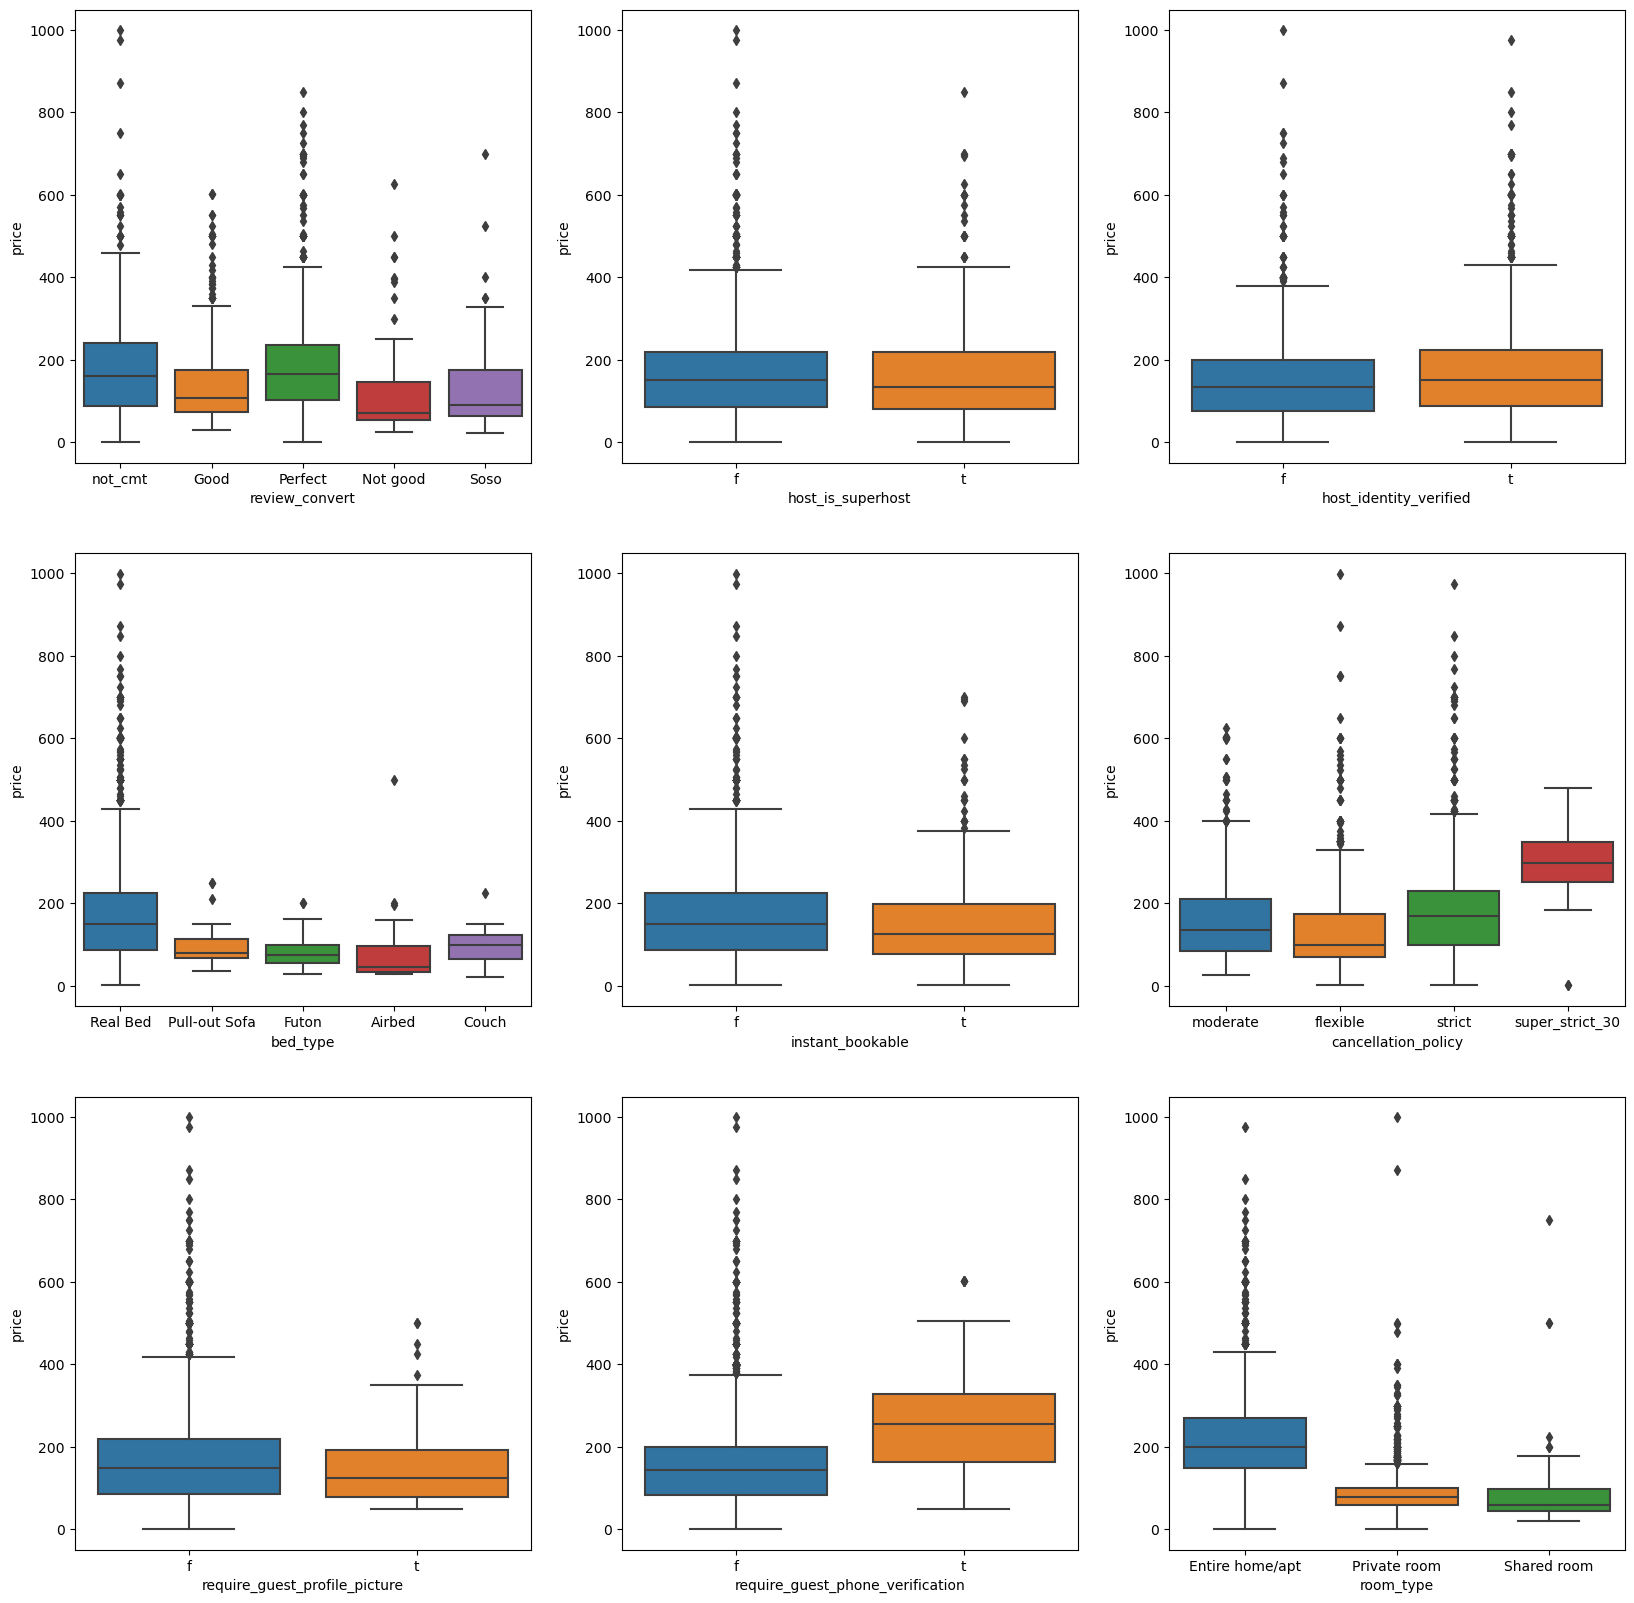

In [51]:
plt.figure(figsize=(20,20))
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(20,20))

for i in range(3):
    for j in range(3):
        if i*3+j < len(category_col):
            sns.boxplot(data=boston_list_clean, x=category_col[i*3+j], y="price", ax = ax[i,j] )
        elif i*3+j == 8:
            sns.boxplot(data=boston_list_clean, x= 'room_type', y="price", ax = ax[i,j] )

From above graph, we have some observes about categorical variables.
According to room type, price of 'Entire home/apt' is much expensive than price of 'Private room' and 'Shared room'. Cancellation policy is seem to be more strict if the price is higher. The more expensive room have a slightly higher in host identity verification ratio and often require guest phone verification. Finally, the 'bed_type' may effect a lot to the price, room with a 'real bed' is often expensive than the without one.

In [52]:
#int_fillmean = lambda x: x.fillna(round(x.mean()))
boston_int = boston_num.select_dtypes(include = ['int'])

boston_int = boston_int.apply(lambda x: x.fillna(x.mode()), axis=0)


#df_num = df_num.drop(['id', 'host_id', 'latitude', 'longitude'], axis=1).astype(float)


In [53]:
boston_num= boston_num.drop(['id','host_id'], axis=1).astype(float)

In [55]:
boston_list_get_dummies.columns

Index(['review_convert_Good', 'review_convert_Not good', 'review_convert_Perfect', 'review_convert_Soso', 'review_convert_not_cmt', 'host_is_superhost_f', 'host_is_superhost_t', 'host_identity_verified_f', 'host_identity_verified_t', 'bed_type_Airbed', 'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed', 'instant_bookable_f', 'instant_bookable_t', 'cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict', 'cancellation_policy_super_strict_30', 'require_guest_profile_picture_f', 'require_guest_profile_picture_t', 'require_guest_phone_verification_f', 'require_guest_phone_verification_t'], dtype='object')

In [56]:
boston_list_get_dummies=boston_list_get_dummies[['review_convert_Good', 'review_convert_Not good', 'review_convert_Perfect', 'review_convert_Soso', 'review_convert_not_cmt', 'host_is_superhost_t', 'host_identity_verified_t', 'bed_type_Airbed', 'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull-out Sofa','bed_type_Real Bed', 'instant_bookable_t', 'cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict', 'cancellation_policy_super_strict_30', 'require_guest_profile_picture_t', 'require_guest_phone_verification_t']]


In [57]:
boston = pd.concat([boston_num, boston_list_get_dummies], axis=1)
boston.shape

(3585, 42)

In [59]:
# drop listing price is 1 dollar
boston = boston[boston['price'] != 1]
# # we will also exlude some outliers of the price > 1.5 IQR
boston = boston[boston['price'] < 423]

In [61]:
boston['cleaning_fee'].fillna(boston['cleaning_fee'].mean(),inplace= True)
boston['reviews_per_month'].fillna(0,inplace= True)



In [62]:
for c in boston.columns:
    if boston[c].isna().sum()>0:
        boston[c].fillna(boston[c].mode()[0],inplace=True)
        

# Data Modeling (Build Prediction Model)

In [70]:
X = boston.drop("price", axis=1)
Y = boston['price']

X_train, X_test,y_train, y_test = train_test_split(X, Y, test_size= 0.2,random_state= 1)

# y= (Y-Y.mean())/ Y.std()

In [72]:
model_name = {'xgb' : xgb.XGBRegressor(n_estimators=150, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.7, random_state=1),
             'Lasso': Lasso(), 'LR': LinearRegression()}

In [73]:
for name, model in model_name.items():
    
    print("model {0}: ".format(name))
    cv = RepeatedKFold(n_splits=5 , n_repeats=3)
    scores = cross_val_score(model, X, Y, scoring='r2', cv=cv, n_jobs=-1)
    scores = np.abs(scores)
    print('Mean score: %.3f (%.3f)' % ( scores.mean(), scores.std()) )

model xgb: 
Mean loss: 0.710 (0.022)
model Lasso: 
Mean loss: 1775.577 (4503.278)
model LR: 
Mean loss: 1022.991 (2513.630)


# Evaluate the Results

In [ ]:
xgbmodel= model_name['xgb']
xgbmodel.fit(X_train, y_train)
y_pred = xgbmodel.predict(X_test)


[ 0 39 26 29 30 36  1 13 31 28 32 16 35 27 12 17 24 10 19 15 20 23 14 11
 34 21 37  9 22  5 33  3  2 18 25  8  7 38  4 40  6]


(0.0, 41.0)

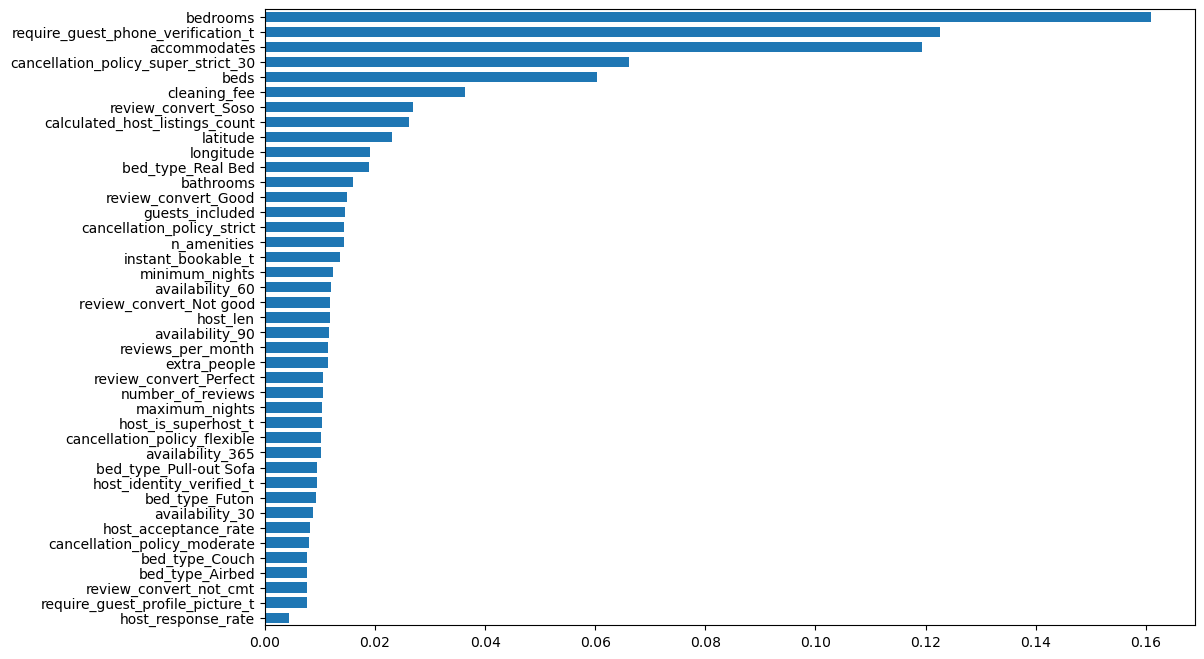

In [75]:

tree_importance_sorted_idx = np.argsort(xgbmodel.feature_importances_)
print(tree_importance_sorted_idx)

tree_indices = np.arange(0, len(xgbmodel.feature_importances_)) + 0.5

fig, ax1 = plt.subplots(1, 1,  figsize=(12, 8))
ax1.barh(tree_indices, xgbmodel.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X_train.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(xgbmodel.feature_importances_)))

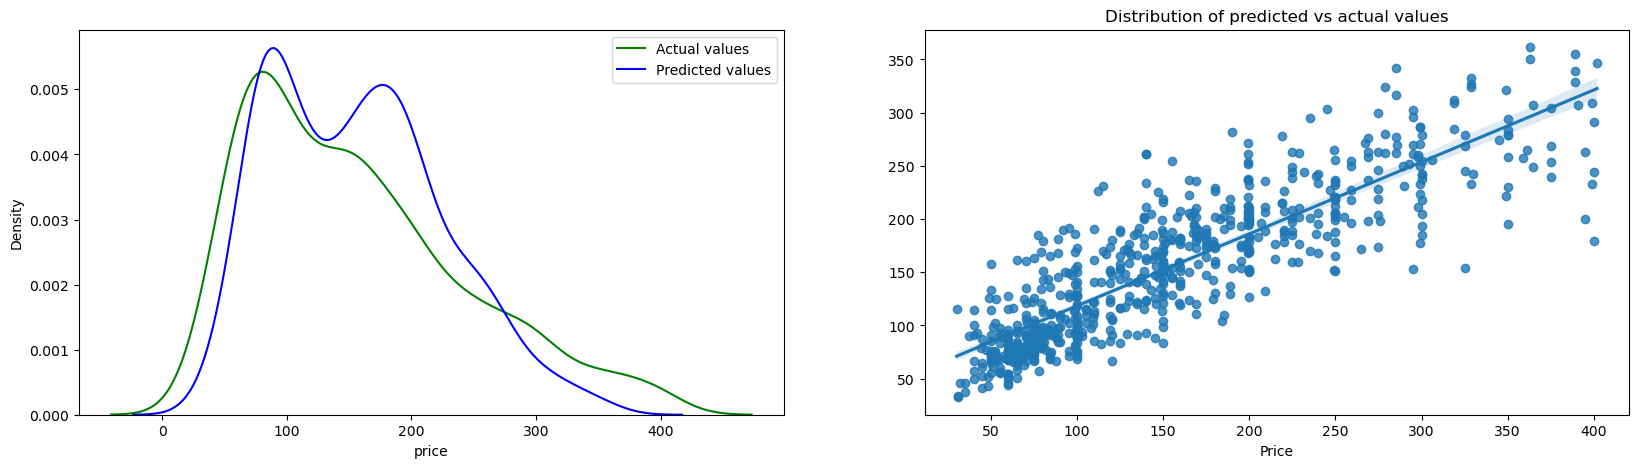

In [79]:
plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
ax1 = sns.kdeplot(data=y_test, color="g", label='Actual values')
ax2 = sns.kdeplot(data=y_pred, color="b", label='Predicted values')
plt.legend();

plt.subplot(1,2,2)
sns.regplot(x=y_test, y=y_pred)
plt.title('Distribution of predicted vs actual values')
plt.xlabel('Price');

In [80]:
metrics.r2_score(y_pred,y_test)

0.5708903712434927

Next, I use permutation_importance to show importance score in average! 

Accuracy on test data: 0.71


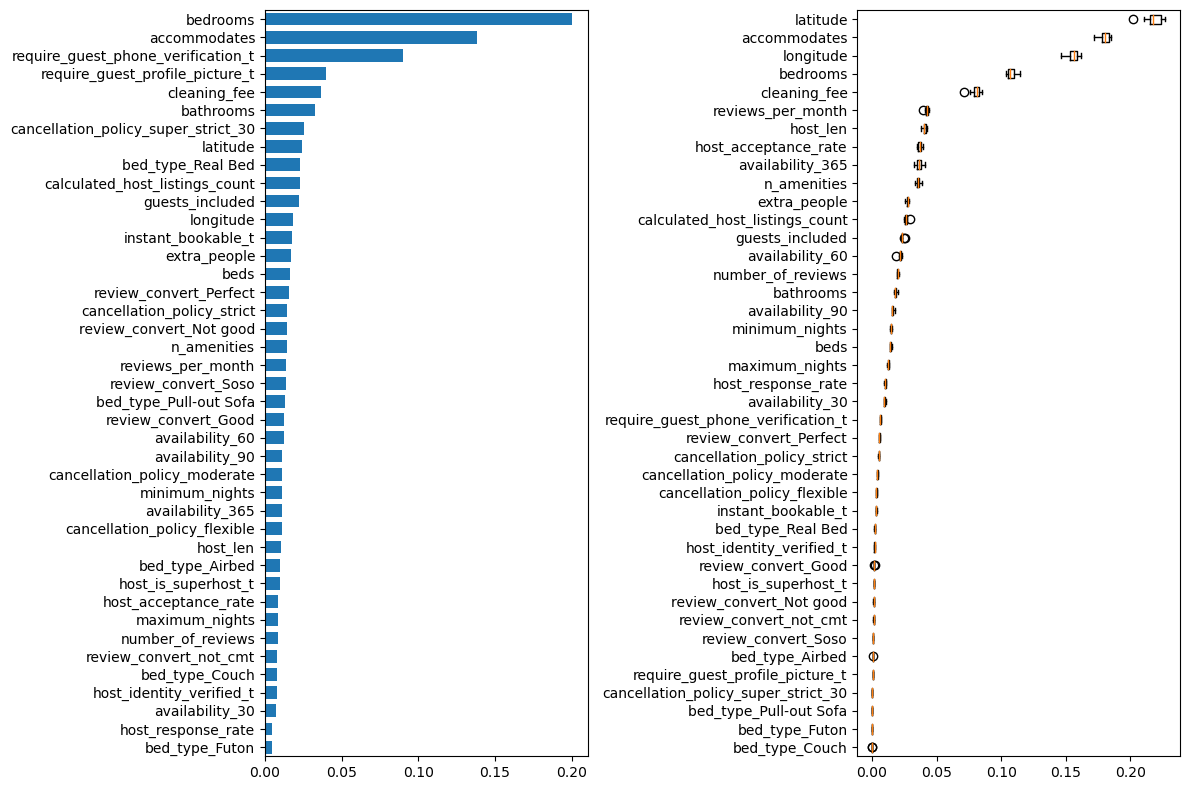

In [84]:
from sklearn.inspection import permutation_importance

clf = xgbmodel
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X_train.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

1. Longitude and Latitude are related to the geographic location of the Airbnb listings at Boston, so it is clear that this is most factor that impact to the price. Location is a crucial factor for travelers when choosing accommodations. The proximity of a listing to popular attractions, transportation hubs, or specific neighborhoods can greatly impact its desirability and, consequently, its price. For example, listings at Bay Vilagge that have a view of ocean may command a higher price. In addition, listings that close to public transportation, restaurants, or shopping areas may be more expensive.

2. the Accommodate has a direct correlation to listing price. This is easy to explain because apartments with more capacity will cost more. The number of bedrooms and bedroom types are also similar.

3. Some features related to the listing's feedback and review score, such as reviews_per_month, host_acceptance_rate, are also worth noting. Positive feedback and high approval rate will increase the reputation of the listing and directly affect the price.

# Answer the Business Questions

1. Is there a trend in house prices?
    - Yes, Listing prices depend on time factors and the law of supply and demand. It changes seasonally or is affected by non-annual events.
2. which neighborhood has highest price?
    - Three highest are: Bay Village, South Boston Waterfront and Leather District
    - If you want to rent cheaper home in Boston, you may looking to Mattapan, Hyde Park and Dorchester.
3. What are factors that have most impact on a house’s price?
    - The most affect factor of a listing is its address, then the accommodation and followed by several factor: cleaning_fee, reviews_per_month, host_len, host_acceptance_rate.
    - The importance conclusion is online reviews will affect the value of the listing and in turn will affect the price.

# future plan

1. Answer the question which factor is importance for home rental investor in Boston?
2. Using NLP technique to analyse reviews data and text listings data